<h1 align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/8/82/Las_Vegas_slot_machines.jpg" width="480px" /></br>
  Machine Learning for Economists Winter 2020/21 </br>
</h1>
<h2 align="center">Lab 8: Multi-Armed Bandits</h2>
<h3 align="center">Pascal Budner & Mario Müller | Februrary 5th, 2021</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

# Classic Randomized Experiment

Suppose that p<sub>1</sub> = .05 and p<sub>2</sub> = .1. If you ran a classic randomized experiment, how many observations would you need to sample into each treatment arm to detect a difference between arm 1 and arm 2 at a two-sided significance level of .99 and with power of .8? Adjust the code from the lecture notes to find out. Also, what would be the regret?

## Required Observations

In [2]:
# Set Parameters
p_1 = 0.05
p_2 = 0.1
sig = 0.01
power = 0.8

es = sms.proportion_effectsize(p_1, p_2)  # Calculate effect size comparing two proportions

# Calculate number of observations to sample
obs = sms.NormalIndPower().solve_power(es, power=power, alpha=sig, ratio=1) 

print("We need to sample {:.0f} obversations per treatment arm.".format(obs))

We need to sample 631 obversations per treatment arm.


## Regret

In [3]:
# In this randomized experiment, we would play the wrong arm (i.e., arm 1) 681 times (number of observations).
# Hence, we miss a (p_2 - p_1) chance of getting a reward.

regret = (p_2 - p_1) * obs
print("The regret is {:.0f} before we realize which arm is better at a power of {} and p < {}.".format(regret, power, sig))

The regret is 32 before we realize which arm is better at a power of 0.8 and p < 0.01.


# Multi-Armed Bandit Setting

In [4]:
class Bandit:
    def __init__(self, k, eps, draws, mu):
        self.k = k  # Number of arms
        self.eps = eps  # Search probability
        self.draws = draws  # Number of draws
        self.mu = np.array(mu)

        self.n = 0  # Step count
        self.k_n = np.zeros(k)  # Step count for each arm

        self.rewards = np.zeros(draws)
        self.cum_rewards = np.zeros(draws)
    
        self.total_cum_reward = 0 # Total cumulative reward
        self.total_cum_k_reward = np.zeros(k)  # Total cumulative reward for each arm
        self.avg_k_reward = np.zeros(k)

    def pull(self):
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            if min(self.avg_k_reward) == max(self.avg_k_reward):
                a = np.random.choice(self.k)
            else:
                a = np.argmax(self.avg_k_reward)
        
        if np.random.random() < self.mu[a]:
            reward = 1
        else:
            reward = 0

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.total_cum_reward += reward
        
        # Update results for a_k
        self.total_cum_k_reward[a] += reward
        self.avg_k_reward[a] = self.total_cum_k_reward[a] / self.k_n[a]
        
        return reward
    
    def run(self):
        for i in range(self.draws):
            reward = self.pull()
            self.rewards[i] = reward
            self.cum_rewards += reward

## Comparing Initial Bandits with Greedy Action and ε-Greedy Selection 

In [5]:
# Parameters for Bandit and Simulation
k = 2  # Number of arms
p_values = [0.05, 0.1]
draws = 1000
simulations = 2000

eps0_cum_rewards = np.zeros(simulations)  # Initialize array to store cum. rewards for greedy
eps01_cum_rewards = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.1
eps03_cum_rewards = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.3

eps0_total_reward = 0  # Stores rewards over all simulations
eps01_total_reward = 0  # Stores rewards over all simulations
eps03_total_reward = 0  # Stores rewards over all simulations

for i in range(simulations):
    eps0 = Bandit(k, 0, draws, p_values)
    eps01 = Bandit(k, 0.1, draws, p_values)
    eps03 = Bandit(k, 0.3, draws, p_values)

    eps0.run()
    eps01.run()
    eps03.run()

    eps0_cum_rewards[i] = eps0.total_cum_reward
    eps01_cum_rewards[i] = eps01.total_cum_reward
    eps03_cum_rewards[i] = eps03.total_cum_reward

    eps0_total_reward += eps0.total_cum_reward
    eps01_total_reward += eps01.total_cum_reward
    eps03_total_reward += eps03.total_cum_reward

eps0_avg_reward = eps0_total_reward / simulations
eps01_avg_reward = eps01_total_reward / simulations
eps03_avg_reward = eps03_total_reward / simulations

print(f'Average reward using greedy selection is {eps0_avg_reward}')
print(f'Average reward using ε-greedy selection (ε=0.1) is {eps01_avg_reward}')
print(f'Average reward using ε-greedy selection (ε=0.3) is {eps03_avg_reward}')

Average reward using greedy selection is 82.7545
Average reward using ε-greedy selection (ε=0.1) is 91.7235
Average reward using ε-greedy selection (ε=0.3) is 89.5035


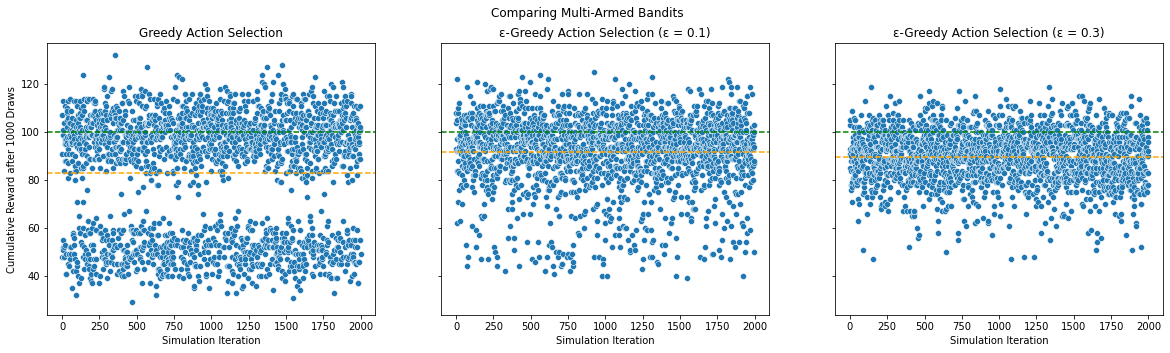

In [7]:
# Visualize Simulation Results
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 5))
fig.suptitle('Comparing Multi-Armed Bandits')

# Greedy Action Selection
sns.scatterplot(ax=axes[0], data=eps0_cum_rewards)
axes[0].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0].axhline(eps0_avg_reward, color='orange', linestyle='--')
axes[0].set_title('Greedy Action Selection')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[1], data=eps01_cum_rewards)
axes[1].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[1].axhline(eps01_avg_reward, color='orange', linestyle='--')
axes[1].set_title('ε-Greedy Action Selection (ε = 0.1)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[2], data=eps03_cum_rewards)
axes[2].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[2].axhline(eps03_avg_reward, color='orange', linestyle='--')
axes[2].set_title('ε-Greedy Action Selection (ε = 0.3)')

for ax in axes.flat:
    ax.set(xlabel='Simulation Iteration',
           ylabel='Cumulative Reward after {} Draws'.format(draws))

plt.show()

## Changing Reward Distributions

In [9]:
# Parameters for Bandit and Simulation
k = 2  # Number of arms
p_values_new = [0.05, 0.5]
draws = 1000
simulations = 2000

eps0_cum_rewards_new = np.zeros(simulations)  # Initialize array to store cum. rewards for greedy
eps01_cum_rewards_new = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.1
eps03_cum_rewards_new = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.3

eps0_total_reward_new = 0  # Stores rewards over all simulations
eps01_total_reward_new = 0  # Stores rewards over all simulations
eps03_total_reward_new = 0  # Stores rewards over all simulations

for i in range(simulations):
    eps0_new = Bandit(k, 0, draws, p_values_new)
    eps01_new = Bandit(k, 0.1, draws, p_values_new)
    eps03_new = Bandit(k, 0.3, draws, p_values_new)

    eps0_new.run()
    eps01_new.run()
    eps03_new.run()

    eps0_cum_rewards_new[i] = eps0_new.total_cum_reward
    eps01_cum_rewards_new[i] = eps01_new.total_cum_reward
    eps03_cum_rewards_new[i] = eps03_new.total_cum_reward

    eps0_total_reward_new += eps0_new.total_cum_reward
    eps01_total_reward_new += eps01_new.total_cum_reward
    eps03_total_reward_new += eps03_new.total_cum_reward

eps0_avg_reward_new = eps0_total_reward_new / simulations
eps01_avg_reward_new = eps01_total_reward_new / simulations
eps03_avg_reward_new = eps03_total_reward_new / simulations

print(f'Average reward using greedy selection is {eps0_avg_reward_new}')
print(f'Average reward using ε-greedy selection (ε=0.1) is {eps01_avg_reward_new}')
print(f'Average reward using ε-greedy selection (ε=0.3) is {eps03_avg_reward_new}')

Average reward using greedy selection is 455.078
Average reward using ε-greedy selection (ε=0.1) is 475.477
Average reward using ε-greedy selection (ε=0.3) is 431.6695


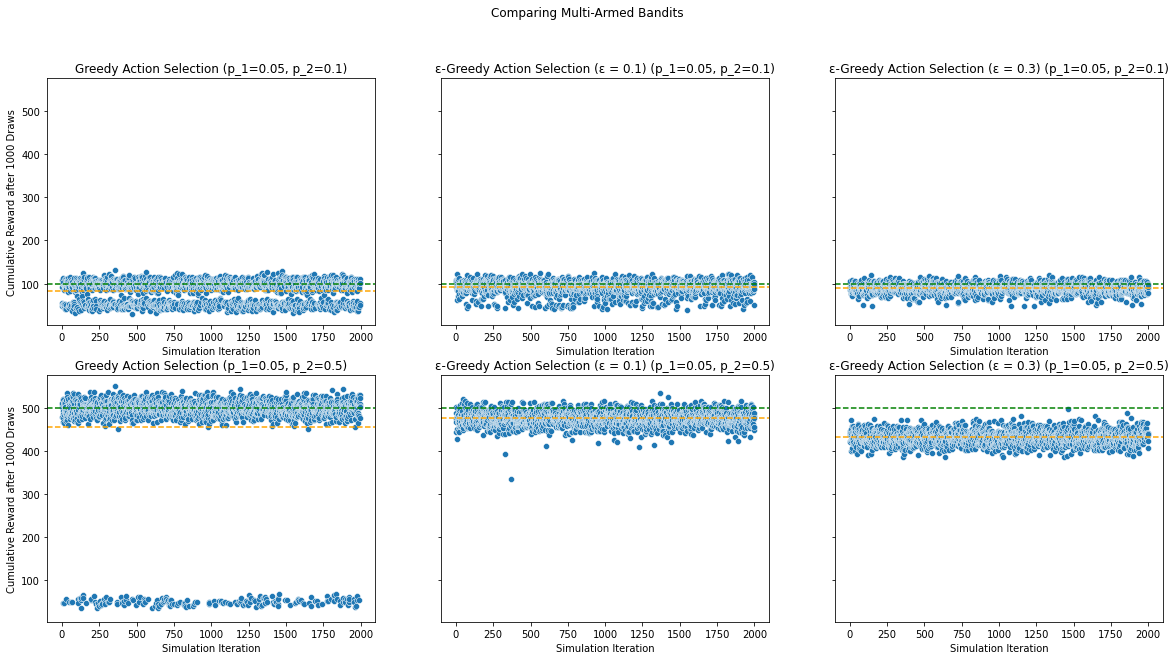

In [10]:
# Visualize Simulation Results
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20, 10))
fig.suptitle('Comparing Multi-Armed Bandits')

# Greedy Action Selection
sns.scatterplot(ax=axes[0, 0], data=eps0_cum_rewards)
axes[0, 0].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 0].axhline(eps0_avg_reward, color='orange', linestyle='--')
axes[0, 0].set_title('Greedy Action Selection (p_1=0.05, p_2=0.1)')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[0, 1], data=eps01_cum_rewards)
axes[0, 1].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 1].axhline(eps01_avg_reward, color='orange', linestyle='--')
axes[0, 1].set_title('ε-Greedy Action Selection (ε = 0.1) (p_1=0.05, p_2=0.1)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[0, 2], data=eps03_cum_rewards)
axes[0, 2].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 2].axhline(eps03_avg_reward, color='orange', linestyle='--')
axes[0, 2].set_title('ε-Greedy Action Selection (ε = 0.3) (p_1=0.05, p_2=0.1)')

# Greedy Action Selection
sns.scatterplot(ax=axes[1, 0], data=eps0_cum_rewards_new)
axes[1, 0].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 0].axhline(eps0_avg_reward_new, color='orange', linestyle='--')
axes[1, 0].set_title('Greedy Action Selection (p_1=0.05, p_2=0.5)')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[1, 1], data=eps01_cum_rewards_new)
axes[1, 1].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 1].axhline(eps01_avg_reward_new, color='orange', linestyle='--')
axes[1, 1].set_title('ε-Greedy Action Selection (ε = 0.1) (p_1=0.05, p_2=0.5)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[1, 2], data=eps03_cum_rewards_new)
axes[1, 2].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 2].axhline(eps03_avg_reward_new, color='orange', linestyle='--')
axes[1, 2].set_title('ε-Greedy Action Selection (ε = 0.3) (p_1=0.05, p_2=0.5)')

for ax in axes.flat:
    ax.set(xlabel='Simulation Iteration',
           ylabel='Cumulative Reward after {} Draws'.format(draws))

plt.show()

## Increasing the Number of Bandits

In [11]:
# Parameters for Bandit and Simulation
k = 5  # Number of arms, NOTE: Now we have 5 arms ;)
p_values_all = [0.05, 0.1, 0.01, 0.11, 0.4]
draws = 1000
simulations = 2000

eps0_cum_rewards_all = np.zeros(simulations)  # Initialize array to store cum. rewards for greedy
eps01_cum_rewards_all = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.1
eps03_cum_rewards_all = np.zeros(simulations)  # Initialize array to store cum. rewards for ε = 0.3

eps0_total_reward_all = 0  # Stores rewards over all simulations
eps01_total_reward_all = 0  # Stores rewards over all simulations
eps03_total_reward_all = 0  # Stores rewards over all simulations

for i in range(simulations):
    eps0_all = Bandit(k, 0, draws, p_values_all)
    eps01_all = Bandit(k, 0.1, draws, p_values_all)
    eps03_all = Bandit(k, 0.3, draws, p_values_all)

    eps0_all.run()
    eps01_all.run()
    eps03_all.run()

    eps0_cum_rewards_all[i] = eps0_all.total_cum_reward
    eps01_cum_rewards_all[i] = eps01_all.total_cum_reward
    eps03_cum_rewards_all[i] = eps03_all.total_cum_reward

    eps0_total_reward_all += eps0_all.total_cum_reward
    eps01_total_reward_all += eps01_all.total_cum_reward
    eps03_total_reward_all += eps03_all.total_cum_reward

eps0_avg_reward_all = eps0_total_reward_all / simulations
eps01_avg_reward_all = eps01_total_reward_all / simulations
eps03_avg_reward_all = eps03_total_reward_all / simulations

print(f'Average reward using greedy selection is {eps0_avg_reward_all}')
print(f'Average reward using ε-greedy selection (ε=0.1) is {eps01_avg_reward_all}')
print(f'Average reward using ε-greedy selection (ε=0.3) is {eps03_avg_reward_all}')

Average reward using greedy selection is 272.9545
Average reward using ε-greedy selection (ε=0.1) is 356.4795
Average reward using ε-greedy selection (ε=0.3) is 313.679


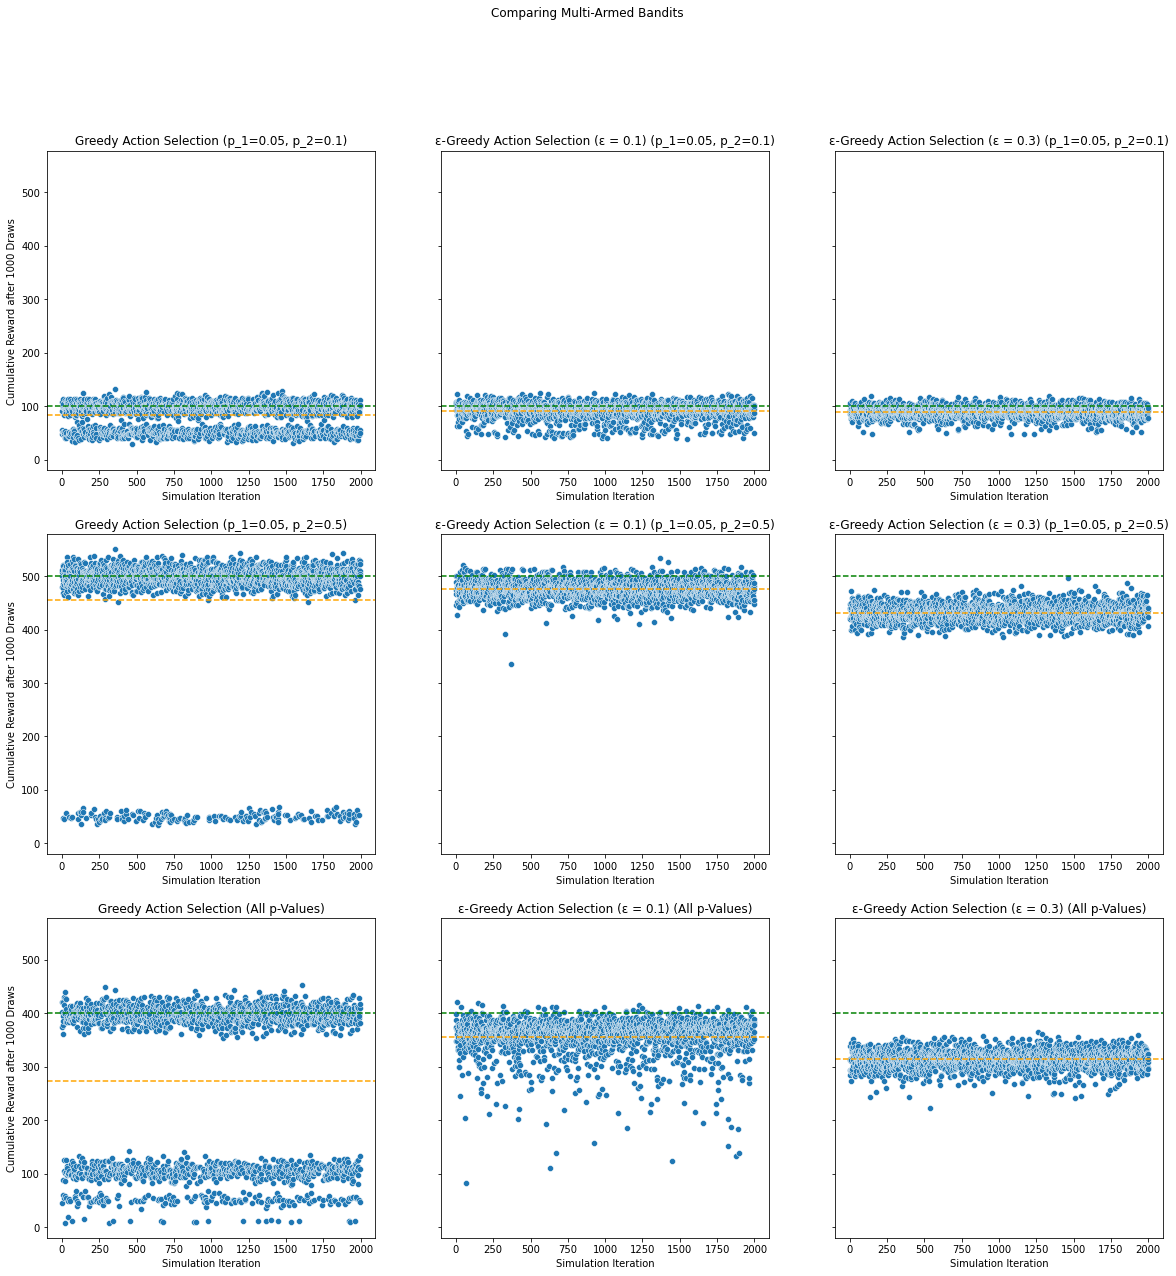

In [12]:
# Visualize Simulation Results
fig, axes = plt.subplots(3, 3, sharey=True, figsize=(20, 20))
fig.suptitle('Comparing Multi-Armed Bandits')

# Greedy Action Selection
sns.scatterplot(ax=axes[0, 0], data=eps0_cum_rewards)
axes[0, 0].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 0].axhline(eps0_avg_reward, color='orange', linestyle='--')
axes[0, 0].set_title('Greedy Action Selection (p_1=0.05, p_2=0.1)')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[0, 1], data=eps01_cum_rewards)
axes[0, 1].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 1].axhline(eps01_avg_reward, color='orange', linestyle='--')
axes[0, 1].set_title('ε-Greedy Action Selection (ε = 0.1) (p_1=0.05, p_2=0.1)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[0, 2], data=eps03_cum_rewards)
axes[0, 2].axhline(max(p_values) * draws, color='green', linestyle='--')
axes[0, 2].axhline(eps03_avg_reward, color='orange', linestyle='--')
axes[0, 2].set_title('ε-Greedy Action Selection (ε = 0.3) (p_1=0.05, p_2=0.1)')

# Greedy Action Selection
sns.scatterplot(ax=axes[1, 0], data=eps0_cum_rewards_new)
axes[1, 0].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 0].axhline(eps0_avg_reward_new, color='orange', linestyle='--')
axes[1, 0].set_title('Greedy Action Selection (p_1=0.05, p_2=0.5)')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[1, 1], data=eps01_cum_rewards_new)
axes[1, 1].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 1].axhline(eps01_avg_reward_new, color='orange', linestyle='--')
axes[1, 1].set_title('ε-Greedy Action Selection (ε = 0.1) (p_1=0.05, p_2=0.5)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[1, 2], data=eps03_cum_rewards_new)
axes[1, 2].axhline(max(p_values_new) * draws, color='green', linestyle='--')
axes[1, 2].axhline(eps03_avg_reward_new, color='orange', linestyle='--')
axes[1, 2].set_title('ε-Greedy Action Selection (ε = 0.3) (p_1=0.05, p_2=0.5)')

# Greedy Action Selection
sns.scatterplot(ax=axes[2, 0], data=eps0_cum_rewards_all)
axes[2, 0].axhline(max(p_values_all) * draws, color='green', linestyle='--')
axes[2, 0].axhline(eps0_avg_reward_all, color='orange', linestyle='--')
axes[2, 0].set_title('Greedy Action Selection (All p-Values)')

# ε-Greedy Action Selection (ε = 0.1)
sns.scatterplot(ax=axes[2, 1], data=eps01_cum_rewards_all)
axes[2, 1].axhline(max(p_values_all) * draws, color='green', linestyle='--')
axes[2, 1].axhline(eps01_avg_reward_all, color='orange', linestyle='--')
axes[2, 1].set_title('ε-Greedy Action Selection (ε = 0.1) (All p-Values)')

# ε-Greedy Action Selection (ε = 0.3)
sns.scatterplot(ax=axes[2, 2], data=eps03_cum_rewards_all)
axes[2, 2].axhline(max(p_values_all) * draws, color='green', linestyle='--')
axes[2, 2].axhline(eps03_avg_reward_all, color='orange', linestyle='--')
axes[2, 2].set_title('ε-Greedy Action Selection (ε = 0.3) (All p-Values)')

for ax in axes.flat:
    ax.set(xlabel='Simulation Iteration',
           ylabel='Cumulative Reward after {} Draws'.format(draws))

plt.show()